In [1]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=eb03a4241439c616ccc50ffba441eabfacd5ee9371914cf7248d4f06c1fd0575
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [9]:
# ViT + MaxViT Hybrid (Performance VS ViT Variants)

import torch
import timm
from transformers import ViTModel

vit_configs = [
    ("tiny", "vit_tiny_patch16_224", 192),
    ("small", "vit_small_patch16_224", 384),
    ("base", "google/vit-base-patch16-224-in21k", 768),
    ("large", "google/vit-large-patch16-224-in21k", 1024),
    ("huge", "google/vit-huge-patch14-224-in21k", 1280)
]

for name, model_id, dim in vit_configs:
    print(f"\n🔍 Checking ViT Variant: {name}")

    try:
        if "vit_tiny" in model_id or "vit_small" in model_id:
            vit_model = timm.create_model(model_id, pretrained=True, features_only=False)

            class WrappedViT(torch.nn.Module):
                def __init__(self, model):
                    super().__init__()
                    self.model = model
                def forward(self, x):
                    x = self.model.forward_features(x)
                    return type('', (), {'last_hidden_state': x.unsqueeze(1)})()

            vit_model = WrappedViT(vit_model)
        else:
            vit_model = ViTModel.from_pretrained(model_id)

        print(f"✅ {name} loaded successfully.")

    except Exception as e:
        print(f"❌ Skipped {name}: {str(e)}")
        continue



🔍 Checking ViT Variant: tiny


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

✅ tiny loaded successfully.

🔍 Checking ViT Variant: small


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ small loaded successfully.

🔍 Checking ViT Variant: base
✅ base loaded successfully.

🔍 Checking ViT Variant: large
✅ large loaded successfully.

🔍 Checking ViT Variant: huge
✅ huge loaded successfully.


In [ ]:
# ViT + MaxViT Hybrid (Performance VS ViT Variants)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

def create_model(vit_dim=768, vit_model=None, dropout=0.3):
    class ViT_MaxViT_Hybrid(torch.nn.Module):
        def __init__(self, num_classes=2):
            super().__init__()
            self.vit = vit_model
            self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
            for p in self.vit.parameters(): p.requires_grad = False
            for p in self.maxvit.parameters(): p.requires_grad = False
            maxvit_dim = self.maxvit.head.in_features
            self.maxvit.head = torch.nn.Identity()
            self.classifier = torch.nn.Sequential(
                torch.nn.Linear(vit_dim + maxvit_dim, 512),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout),
                torch.nn.Linear(512, num_classes)
            )
        def forward(self, x):
            vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0] if hasattr(self.vit, "pixel_values") \
                else self.vit(x).last_hidden_state[:, 0]
            max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
            return self.classifier(torch.cat((vit_cls, max_feat), dim=1))
    return ViT_MaxViT_Hybrid()

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs),
        confusion_matrix(all_labels, all_preds)
    )

def run_vit_variant_experiment(npz_path, device='cuda'):
    vit_configs = [
        ("tiny", "vit_tiny_patch16_224", 192),
        ("small", "vit_small_patch16_224", 384),
        ("base", "google/vit-base-patch16-224-in21k", 768),
        ("large", "google/vit-large-patch16-224-in21k", 1024),
        ("huge", "google/vit-huge-patch14-224-in21k", 1280)
    ]
    results = []

    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    for name, model_id, dim in vit_configs:
        torch.cuda.empty_cache()
        print(f"\n🔍 Checking ViT Variant: {name}")
        try:
            if "vit_tiny" in model_id or "vit_small" in model_id:
                raw_model = timm.create_model(model_id, pretrained=True, features_only=False)
                class WrappedViT(torch.nn.Module):
                    def __init__(self, model):
                        super().__init__()
                        self.model = model
                    def forward(self, x):
                        x = self.model.forward_features(x)
                        return type('', (), {'last_hidden_state': x.unsqueeze(1).squeeze(1)})()
                vit_model = WrappedViT(raw_model)
            else:
                vit_model = ViTModel.from_pretrained(model_id)
            print(f"✅ {name} loaded successfully.")
        except Exception as e:
            print(f"❌ {name} not available: {e}")
            continue

        model = create_model(vit_dim=dim, vit_model=vit_model).to(device)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=1e-3)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        scaler = torch.cuda.amp.GradScaler()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        for p in model.classifier.parameters(): p.requires_grad = True

        for epoch in range(5):
            print(f"\nEpoch {epoch+1}/5")
            if epoch == 3:
                for p in model.vit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})

            model.train()
            for imgs, labels in tqdm(train_loader, desc=f"{name} - Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    out = model(imgs)
                    loss = criterion(out, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            scheduler.step(epoch + 1)

            prec, rec, f1, roc, cm = evaluate_model(model, val_loader, device)
            print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        prec, rec, f1, roc, _ = evaluate_model(model, val_loader, device)
        results.append({
            'ViT Variant': name,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC-AUC': roc
        })

    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    for metric in ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        plt.plot(df['ViT Variant'], df[metric], label=metric, linewidth=2, marker='o')
    plt.xlabel('ViT Variant', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs ViT Backbone Variant', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("vit_variant_vs_metrics.pdf", format="pdf")
    plt.show()
    return df

# Run the test
df_results = run_vit_variant_experiment('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_results)



🔍 Checking ViT Variant: tiny
✅ tiny loaded successfully.


/tmp/ipykernel_35/645147332.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/5


tiny - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6139 | Recall: 0.5870 | F1: 0.6001 | ROC-AUC: 0.6551
CM:
[[432 261]
 [292 415]]

Epoch 2/5


tiny - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6501 | Recall: 0.4441 | F1: 0.5277 | ROC-AUC: 0.6530
CM:
[[524 169]
 [393 314]]

Epoch 3/5


tiny - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6260 | Recall: 0.6605 | F1: 0.6428 | ROC-AUC: 0.6699
CM:
[[414 279]
 [240 467]]

Epoch 4/5


tiny - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6157 | Recall: 0.7001 | F1: 0.6552 | ROC-AUC: 0.6880
CM:
[[384 309]
 [212 495]]

Epoch 5/5


tiny - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6773 | Recall: 0.6294 | F1: 0.6525 | ROC-AUC: 0.7137
CM:
[[481 212]
 [262 445]]



🔍 Checking ViT Variant: small
✅ small loaded successfully.


/tmp/ipykernel_35/645147332.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/5


small - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5900 | Recall: 0.7652 | F1: 0.6663 | ROC-AUC: 0.6621
CM:
[[317 376]
 [166 541]]

Epoch 2/5


small - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6040 | Recall: 0.6407 | F1: 0.6218 | ROC-AUC: 0.6561
CM:
[[396 297]
 [254 453]]

Epoch 3/5


small - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6382 | Recall: 0.6337 | F1: 0.6359 | ROC-AUC: 0.6763
CM:
[[439 254]
 [259 448]]

Epoch 4/5


small - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6900 | Recall: 0.6139 | F1: 0.6497 | ROC-AUC: 0.7197
CM:
[[498 195]
 [273 434]]

Epoch 5/5


small - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7046 | Recall: 0.5431 | F1: 0.6134 | ROC-AUC: 0.7226
CM:
[[532 161]
 [323 384]]



🔍 Checking ViT Variant: base
✅ base loaded successfully.


/tmp/ipykernel_35/645147332.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/5


base - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5728 | Recall: 0.8515 | F1: 0.6849 | ROC-AUC: 0.6663
CM:
[[244 449]
 [105 602]]

Epoch 2/5


base - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6471 | Recall: 0.5912 | F1: 0.6179 | ROC-AUC: 0.6659
CM:
[[465 228]
 [289 418]]

Epoch 3/5


base - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5850 | Recall: 0.8175 | F1: 0.6820 | ROC-AUC: 0.6922
CM:
[[283 410]
 [129 578]]

Epoch 4/5


base - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6840 | Recall: 0.5389 | F1: 0.6028 | ROC-AUC: 0.7010
CM:
[[517 176]
 [326 381]]

Epoch 5/5


base - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6878 | Recall: 0.5516 | F1: 0.6122 | ROC-AUC: 0.7074
CM:
[[516 177]
 [317 390]]



🔍 Checking ViT Variant: large
✅ large loaded successfully.


/tmp/ipykernel_35/645147332.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/5


large - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6649 | Recall: 0.5417 | F1: 0.5970 | ROC-AUC: 0.6749
CM:
[[500 193]
 [324 383]]

Epoch 2/5


large - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/645147332.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:   5%|▌         | 9/175 [00:05<01:32,  1.79it/s]       

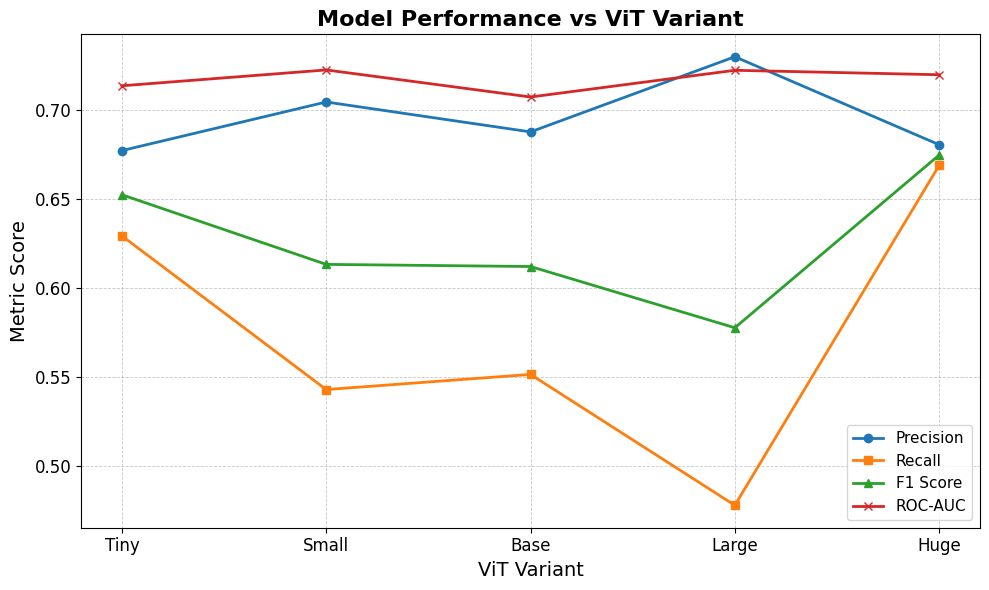

In [1]:
# ViT + MaxViT Hybrid (Performance VS ViT Variants) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# === Data for ViT Variant Comparison ===
data = {
    'ViT Variant': ['Tiny', 'Small', 'Base', 'Large', 'Huge'],
    'Precision': [0.6773, 0.7046, 0.6878, 0.7300, 0.6806],
    'Recall': [0.6294, 0.5431, 0.5516, 0.4781, 0.6690],
    'F1 Score': [0.6525, 0.6134, 0.6122, 0.5778, 0.6748],
    'ROC-AUC': [0.7137, 0.7226, 0.7074, 0.7224, 0.7199]
}

df = pd.DataFrame(data)

# === Plot with Journal Styling ===
plt.figure(figsize=(10, 6))
plt.plot(df['ViT Variant'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['ViT Variant'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['ViT Variant'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['ViT Variant'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# High-quality layout and styling
plt.title('Model Performance vs ViT Variant', fontsize=16, weight='bold')
plt.xlabel('ViT Variant', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()

# === Save the figure as a high-quality PDF ===
plt.savefig("vit_variant_vs_performance.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [2]:
# ViT + MaxViT Hybrid (Performance VS Dataset Variation)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.amp import autocast, GradScaler
from transformers import ViTModel
import timm
import time
import random

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_MaxViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + maxvit_dim, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

# === Train/Eval ===
def train_epoch(model, loader, criterion, opt, device, scaler):
    model.train(); loss_sum = correct = total = 0; start = time.time()
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        with autocast(device_type='cuda'):
            out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item(); total += labels.size(0)
    return loss_sum / total, correct / total, time.time() - start

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                out = model(imgs); loss = criterion(out, labels)
                probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return loss_sum / total, correct / total, precision_score(all_labels, all_preds), \
           recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), \
           roc_auc_score(all_labels, all_probs), confusion_matrix(all_labels, all_preds)

# === Unfreeze ===
def unfreeze_layers(model, vit=False, maxvit=False):
    if vit:
        for p in model.vit.parameters(): p.requires_grad = True
    if maxvit:
        for p in model.maxvit.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

# === Ablation Wrapper ===
def run_data_ablation(npz_file, batch_size=16, num_epochs=10, device='cuda'):
    ratios = [1.0, 0.9, 0.75, 0.5]
    results = []

    full_dataset = JetDataset(npz_file, train=True)
    total_samples = len(full_dataset)

    for r in ratios:
        subset_size = int(total_samples * r)
        subset_indices = random.sample(range(total_samples), subset_size)
        subset = Subset(full_dataset, subset_indices)

        train_size = int(0.8 * len(subset))
        train_set, val_set = torch.utils.data.random_split(subset, [train_size, len(subset) - train_size])

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

        model = ViT_MaxViT_Hybrid().to(device)
        unfreeze_layers(model, vit=False, maxvit=False)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
        scaler = GradScaler()

        best_f1 = 0
        for epoch in range(num_epochs):
            if epoch == 5:
                unfreeze_layers(model, vit=True)
                optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.vit.parameters()), 'lr': 1e-5})
            elif epoch == 9:
                unfreeze_layers(model, vit=True, maxvit=True)
                optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.maxvit.parameters()), 'lr': 1e-5})

            train_epoch(model, train_loader, criterion, optimizer, device, scaler)
            _, _, prec, rec, f1, roc, _ = eval_epoch(model, val_loader, criterion, device)

            if f1 > best_f1:
                best_f1 = f1
                best_result = {
                    "Dataset Used": f"{int(r * 100)}%",
                    "Samples": len(subset),
                    "Precision": prec,
                    "Recall": rec,
                    "F1 Score": f1,
                    "ROC-AUC": roc
                }

        results.append(best_result)

    return results

# Example call:
results = run_data_ablation('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
for r in results: print(r)


2025-05-23 23:10:26.032525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748041826.516775      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748041826.643650      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

100%|██████████| 44/44 [00:09<00:00,  4.69it/s]

{'Dataset Used': '100%', 'Samples': 7000, 'Precision': 0.6531413612565445, 'Recall': 0.7425595238095238, 'F1 Score': 0.6949860724233984, 'ROC-AUC': 0.7513695381998953}
{'Dataset Used': '90%', 'Samples': 6300, 'Precision': 0.6737160120845922, 'Recall': 0.7181964573268921, 'F1 Score': 0.6952455183164458, 'ROC-AUC': 0.7460214858663522}
{'Dataset Used': '75%', 'Samples': 5250, 'Precision': 0.6684981684981685, 'Recall': 0.7087378640776699, 'F1 Score': 0.6880301602262017, 'ROC-AUC': 0.7287850467289719}
{'Dataset Used': '50%', 'Samples': 3500, 'Precision': 0.6241457858769932, 'Recall': 0.7965116279069767, 'F1 Score': 0.6998722860791826, 'ROC-AUC': 0.7410096028220539}


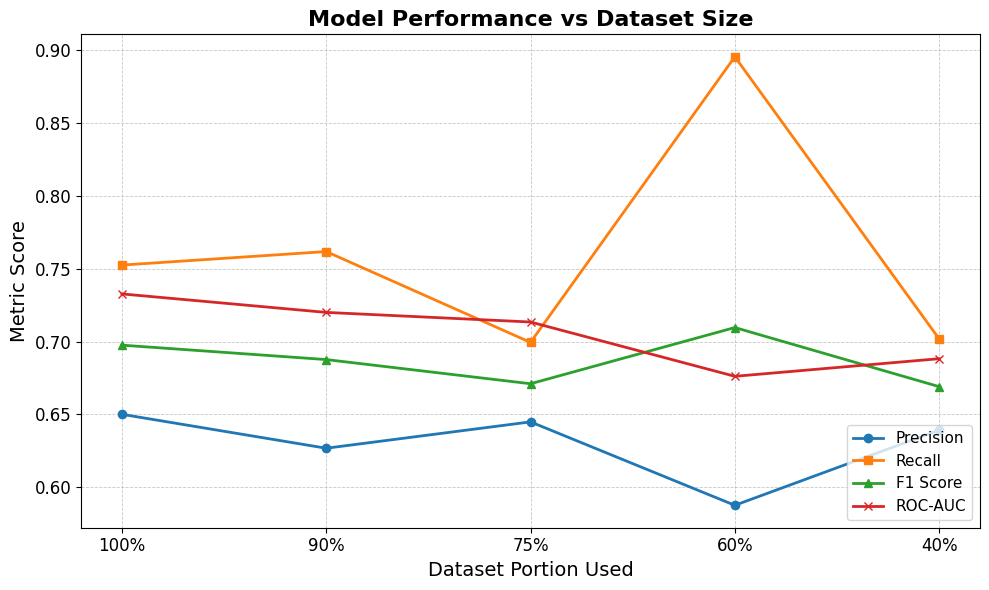

In [1]:
# ViT + MaxViT Hybrid (Performance VS Dataset Variation) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Dataset Used': ['100%', '90%', '75%', '60%', '40%'],
    'Precision': [0.6500, 0.6267, 0.6448, 0.5875, 0.6391],
    'Recall': [0.7525, 0.7618, 0.6994, 0.8956, 0.7018],
    'F1 Score': [0.6975, 0.6876, 0.6710, 0.7096, 0.6690],
    'ROC-AUC': [0.7327, 0.7200, 0.7134, 0.6761, 0.6882]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['Dataset Used'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['Dataset Used'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['Dataset Used'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['Dataset Used'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# Styling
plt.title('Model Performance vs Dataset Size', fontsize=16, weight='bold')
plt.xlabel('Dataset Portion Used', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.savefig("dataset_size_vs_performance_updated.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()
